# STFT (Short Time Fourier Transform) Pulsegenerator for Trapped Ion Quantum Gates

This notebook describes the design outline and architecture of a novel approach to generate pulses for quantum gates in a trapped ion system. It is intended to be be deployed on the Phaser hardware of the Sinara ecosystem.



## Pulses for Quantum Gates

This section briefly discusses some of the design requirements for possible pulses from the perspective of an electrical engineering student recently introduced to trapped ion systems.

|<img src="https://drive.google.com/uc?id=1-YoqlHsgI-3Y4JlxLcJ5wEI_71t5_s3n" alt="drawing" width="700"/>| 
|:--:| 
| *(1) Ion excitation spectrum* |

Exemplary ion excitation spectrum from [\[Berkeley](http://research.physics.berkeley.edu/haeffner/teaching/exp-quant-info/Ion-QC2.pdf)]\. The tones of an entangling gate-pulse need to be detuned from motional sideband excitation frequencies. Therefore precise placement of the tones is of interest.


|<img src="https://drive.google.com/uc?id=190fdh3io6YOcesn8U2Ps4vfL02ZZrTEc" alt="drawing" width="600"/>| 
|:--:| 
| *(2) LUH Pulseshape* |

Phase-space trajectory and corresponding pulse envelope from [\[LUH1](http://de.arxiv.org/pdf/1911.03954.pdf)]\. Due to physical reasons, the trajectories in phase-space of all affected modes of an Ion need to be closed. This is equivalent to (a) ensuring there is little excitation and thus little power leakage from each tone, (b) choosing detunings from the modes that are multiples of the pulse Fourier frequency, and (c) tailoring the frequency content to minimize undesired excitation in so-called spectator modes. (a) is implemented by proper interpolation and shaping. (b) is implemented by design of the STFT. (c) is left to the Physicist to solve.

|<img src="https://drive.google.com/uc?id=1ER0PozJvQGhyyILlsSYqdSl6cThY-AX1" alt="drawing" width="600"/>| 
|:--:| 
| *(3) Weizmann excitation spectrum* |

Some approaches for novel gate designs require for complex pulse spectra like in [\[Weizmann](https://arxiv.org/pdf/1911.03073.pdf)]\. Here many motional modes in an ion crystal (orange markers) get excited simultaniously and the required excitation pulse has many different tones (blue markers).



## Existing Approaches and Hardware

The following are comments on already existing hardware, again without any practical experience with it.

|<img src="https://drive.google.com/uc?id=1O-K8oaHuP1ArAaskVqJXySGGCbdssypJ" alt="drawing" width="600"/>| 
|:--:| 
| *(4) Microwave drive* |

Figure 5 shows the electrode microwave drive from [\[LUH2](https://www.repo.uni-hannover.de/handle/123456789/5174)]\. Here many discrete, analog components implemented in separate devices are responsible for producing a pulse. While this is of course a well engineered and functional design, a more integrated approach has historically yielded better performance in many other fields. On the other hand, the new architecture presented here does not include the (rather critical) power amplifier. 


|<img src="https://drive.google.com/uc?id=1312VU8GVW1_gNyhD8v_ULSbgsYozLyZN" alt="drawing" width="600"/>| 
|:--:| 
| *(5) NIST AWG* |


An AWG used in some trapped ion experiments is the one described in [\[NIST](https://tsapps.nist.gov/publication/get_pdf.cfm?pub_id=912958)]\. While appropriate for many tasks, the limited digital bandwidth, memory and FPGA size make scaling up to more complex pulses or bigger ion crystals challenging. This board is also used to provide $U_\text{shape}$ in the "Microwave drive" figure.






## Interpolation

The following is a quick demonstration of the spectral leackage effects of different interpolators. All can be implemented cheaply without any multiplication. All are fed the same input data sequence (a single sample impulse). The first order CIC (Cascaded Intgrator Convolution filter) is equivalent to a sample and hold approach. The third order CIC would be equivalent to an interpolation with cubic splines (intrinsic limitation of the PDQ device for example). Higher filter orders correspond to higher order splines and can achieve much lower spectral leakage.

(-150.0, 0.0)

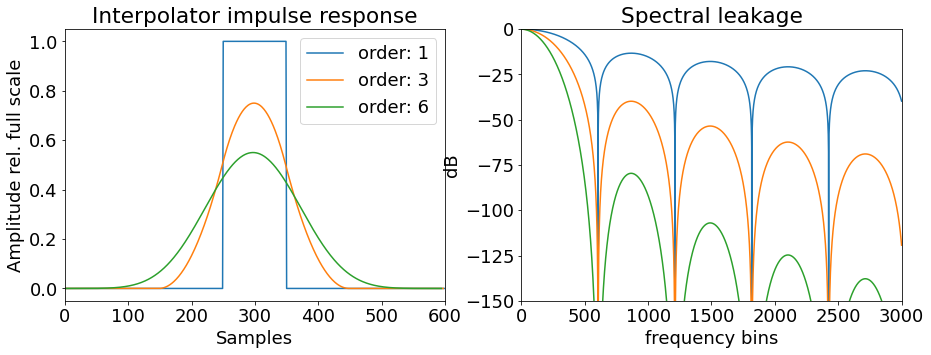

In [ ]:
#@title  { form-width: "1px" }
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
##################################################
## CIC interpolation
##
## Plotting of the impulse responses of different interpolations:
## * Sample and hold interpolation (1st order CIC)
## * Cubic Splines (3rd order CIC)
## * 6th order CIC
## 
##################################################
## Author: Norman Krackow
## Company: QUARTIQ GmbH
## IDE: Spyder
## Version: 2
## Date: 09.06.2020
##################################################


# %% Includes
# ================================================

import numpy as np
import matplotlib.pyplot as plt



# %% Helper functions
# ================================================

def comp_CIC_resp(order,length):
    '''Computes the CIC impulse response (fir kernel) for a given length.'''
    ones=np.ones(length)
    kernel=ones
    for i in range(order-1):
        kernel=np.convolve(ones,kernel)
    
    return kernel/(length**(order-1))


def dbspec(data):
    '''Returns positive freq spectrum in dBFS (+-1). Half width of data input.'''
    
    return 20*np.log10((abs(np.fft.fft(data)[:int(len(data)/2)]))/(len(data)/2))



# %% Parameters
# ================================================

N=100                       # CIC integrator size
max_ord=6                   # maximum order (for plotting)
extra_pad=50                # extra padding factor for better spectral resolution
lobes=5                     # approx. number of lobes to plot



# %% Compute responses and spectra
# ================================================

order=1
pulse1=np.pad(comp_CIC_resp(order,N),int((max_ord-order)*N/2))+10E-10

pulse1_pad=np.pad(pulse1,extra_pad*max_ord*N)*max_ord*extra_pad

spec1=dbspec(pulse1_pad)[:int(max_ord*extra_pad*N/(lobes*2))]



order=3
pulse2=np.pad(comp_CIC_resp(order,N),int((max_ord-order)*N/2))+10E-10

pulse2_pad=np.pad(pulse2,extra_pad*max_ord*N)*max_ord*extra_pad

spec2=dbspec(pulse2_pad)[:int(max_ord*extra_pad*N/(lobes*2))]



order=6
pulse3=np.pad(comp_CIC_resp(order,N),int((max_ord-order)*N/2))+10E-10

pulse3_pad=np.pad(pulse3,extra_pad*max_ord*N)*max_ord*extra_pad

spec3=dbspec(pulse3_pad)[:int(max_ord*extra_pad*N/(lobes*2))]


# %% Plotting
# ================================================

plt.rc('font', size=18)
fig,ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].plot(pulse1,label='order: 1')
ax[0].plot(pulse2,label='order: 3')
ax[0].plot(pulse3,label='order: 6')
ax[0].set_title('Interpolator impulse response')
ax[0].set_ylabel('Amplitude rel. full scale')
ax[0].set_xlabel('Samples')
ax[0].set_xlim(0,len(pulse1))
ax[0].legend(loc='upper right')

ax[1].plot(spec1,label='order: 1')
ax[1].plot(spec2,label='order: 3')
ax[1].plot(spec3,label='order: 6')
ax[1].set_title('Spectral leakage')
ax[1].set_ylabel('dB')
ax[1].set_xlabel('frequency bins')
ax[1].set_xlim(0,len(spec1))
ax[1].set_ylim(-150,0)

## Proposed Implementation

* The phase space trajectory $H(\delta, T)$ of a mode under the influence of a pulse of duration $T$, detuned by $\delta$ with red and blue sidebands is (up to a constant factor) the Short Time Fourier Transform (STFT) of the pulse.
  $$ H(\delta, T) = F(\delta, T) + i G(\delta, T) = \int_0^T \Omega(t) \exp(i \delta t)\, dt $$
  $$ = \int_{-\infty}^\infty x(t)w_T(t)\exp(i \delta t)\, dt$$
  The accumulated phase of a closed trajectory $H(0) = H(T)$ is (up to a constant factor):
  $$ A = \Im \int \dot H(t) \bar H(t)\, dt$$
  * $w_T(t) = 1$ for $t \in [0, T]$ and $0$ else is the pulse window, a.k.a. "shape"
  * $\delta$ is the detuning
  * $x(t) = \sum_{m=-M/2}^{M/2 - 1} a_m \exp(2\pi i f_m t)$ is the spectral content of the pulse, the complex $a_m$ are the tone amplitudes
  * The STFT is invertible and the composition of $x$ using a FFT matches that expression. This expansion allows direct computation of the phase space trajectory from the pulse parametrization.
  * There are constraints and dependencies between $f_m$, $T$, $M$ which will be discussed below. Some are are technical, others are physical (e.g. trajectory closure constraints $T, f_m, \delta$).

*   The new design would utilize modern digital signal processing techniques. With the big FPGA and precise DAC34H84 of the Phaser hardware, tasks such as adding multiple tones, pulse shaping, RF switching, and modulation can be pushed to the digital domain. This makes for a more integrated solution taking up less rack-space and cabling. Moreover, the deterministic nature of digital signal processing can make the whole pulse generation process linear and more repeatable thereby potentially produce higher gate fidelities.

*   As the bulk of the system is basically just HDL code, it can be modified and expanded upon easily. If the need for more tones or a higher resolution interpolation arises, the code can be adapted to fit the needs. If more Qubits need to be controlled individually, the same architecture can be deployed on a bigger system with more ADC channels. The Sinara hardware ecosystem provides all the tools to distribute time, frequency, and data.

*   The system does not rely on bulky AWG sample-data which would require large amounts of memory. As the pulses are basically computed on-the-fly, changing pulse parameters does not require pre-computing the samples. Therefore even a pulse that depends on real-time measurements can be emitted within microseconds.

*   Equalization of downstream analog hardware can easily be done as the tones of the pulse are specified in frequency domain. Therefore you can calibrate the hardware and then store the calibration parameters as additive FFT coefficients.

##  Architecture



| ![Phaser](https://drive.google.com/uc?id=1uXoLnbBg_vO-YHDrnmRdkXfAp6D4a_lt) | 
|:--:| 
| *(6) Architecture block biagram and corresponding Phaser hardware* |

##Overview

The architecture consists of a number of STFT processors, that each get a specific set of complex parameters $a_{0}...a_m$. These are transformed into a complex time domain representation. You can interpret the complex time domain representation as inphase and quadrature components to a final I/Q modulator. In an I/Q modulator the negative frequencies end up below the carrier. 

Each STFT processor can individually adjust the tone spacing by setting different STFT size and interpolation parameters. However, the STFT size will be limited in practice. The time-domain blocks are repeated $P$ times for a full pulse. Taking an FFT of the full pulse would result in $(P-1)$ frequencies with amplitude $0$ between each accessible frequency defined with the $a_m$ parameters.

The outputs are shifted to a desired spectral position by the $f_0$ DDS frequency for every STFT processor respectively and then summed up. An optional overall pulseshape can be applied by either using another set of FFT parameters or by supplying a low resolution time-domain shape. Both get interpolated to the full pulsetime. After this the FPGA drives the DAC at a base sample rate of $500$MHz. The DAC internally interpolates the signal again to $1$GHz and digitally upcoverts it by $f_1$. The DAC has two channels for the inphase and quadrature components to drive an analog IQ modulator which finally upconverts the signal again by $f_2$. 

The combination of the complex DDS $f_1$ and the real (analog) $f_2$ allows placement of the output spectrum far away from possible carrier leakage. The different $f_0$ frequencies allow precise placement of the STFT tones within the $[-50,50]$ MHz window. 







##Parameters


| Parameter  | Description  | Constraint
|---|---|---|
| $R$  | base sample rate  | fixed $500MHz$
| $M$  | STFT size  | powers of 2 (upto eg. 4096)
| $P$  | number repeated STFT blocks  | integer
| $N$  | upsampling factor 1  | 1, 2, 4, 8, 12, 16...
| $a_m$  | complex STFT tone parameters   | complex 16bit fixedpoint
| $b_m$  | pulseshape IFFT parameters  | complex 16bit fixedpoint
| $f_0$  | internal DDS mixing frequency  | $[-50,50]MHz$ ($mHz$ resolution)
| $f_1$  | ADC DDS mixing frequency  | $[-400,400]MHz$ ($mHz$ resolution)
| $f_2$  | external LO frequency  | $[0.3,4.8]GHz$


##Relations

| Parameter  | Description  | Relation |
|---|---|---|
| $L$  | total number of samples | $$L=M\cdot N\cdot P$$ 
| $K$  | upsampling factor 2  | $$K=N\cdot P$$ 
| $t_{pulse}$  | pulse time  | $$t_{pulse}=M\cdot P\cdot N\cdot \frac{1}{R}$$
| $f_\Delta$  | STFT frequency spacing  |$$f_{\Delta}=\frac{R}{M \cdot N}$$
| $B_{STFT}$  | STFT bandwidth |$$B_{STFT}=\frac{R}{N}$$
| $f_{m}$  | tone frequency after upconversion |$$f_{m}=f_0+f_1+f_2\pm m \cdot f_{\Delta}$$







## Example Pulse

The following example is a very simple demonstration with only a single STFT processor and a short pulsetime (so there are not too many samples to compute). Two tones around a carrier frequency need to be generated. Here the red sideband tone is a pure cosine with a relative amlitude of 1/2. The blue sideband tone is a pure sine with relative amplitude 1/4. By adjusting the complex STFT parameters, arbitrary phases can be achieved. 

The pulse is shaped with a Hann window specified in frequency domain. All the STFT and pulseshape parameters are initialized with zero. The parameterset is:

| Parameter  | Description  | Value |
|---|---|---|
| $R$  | base sample rate  | $500MHz$
| $M$  | STFT size  | $1024$
| $P$  | number repeated STFT blocks  | $2$
| $N$  | upsampling factor 1  | $5$
| $a_{10}$  | 10th complex STFT tone parameter (without counting DC)  | $256j$
| $a_{-10}$  | (M-10)th complex STFT tone parameter   | $512$
| $b_0$  | DC pulseshape IFFT parameter  | $512$
| $b_1$  | first pulseshape IFFT parameter  | $256$
| $b_{-1}$  | last pulseshape IFFT parameter  | $256$
| $f_0$  | internal DDS mixing frequency  | $10MHz$
| $f_1$  | ADC DDS mixing frequency  | $200MHz$
| $f_2$  | external LO frequency  | $1GHz$

Following Parameters:

| Parameter  | Description  | Relation | Value |
|---|---|---|---|
| $L$  | total number of samples | $$L=M\cdot N\cdot P$$ | $10240$
| $K$  | upsampling factor 2  | $$K=N\cdot P$$ | $10$
| $T$  | pulse time  | $$T=M\cdot P\cdot N\cdot \frac{1}{R}$$ | $20.04ms$
| $f_\Delta$  | STFT frequency spacing  |$$f_{\Delta}=\frac{R}{M \cdot N}$$ | $97656.25Hz$
| $B_{STFT}$  | STFT bandwidth |$$B_{STFT}=\frac{R}{N}$$ | $100MHz$
| $f_c$  | carrier frequency  |$$f_c=f_0+f_1+f_2$$ | $1.21GHz$

In the script output below you can see some of the simulated pulse characteristics (or click SHOW CODE to see the script):


Total Pulse Time: 20.48us (10240 Samples)


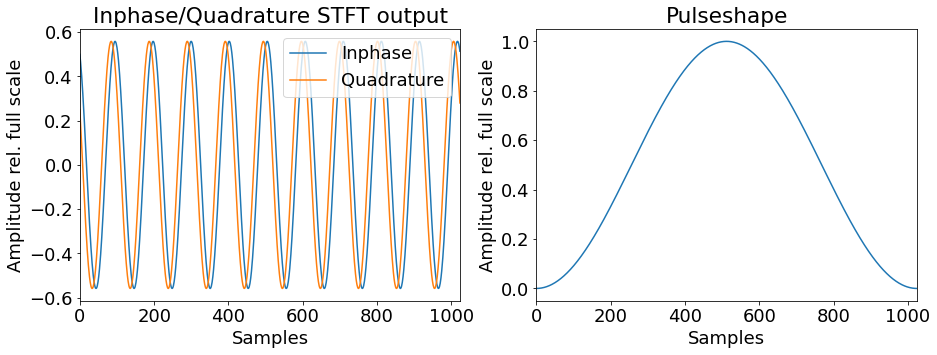

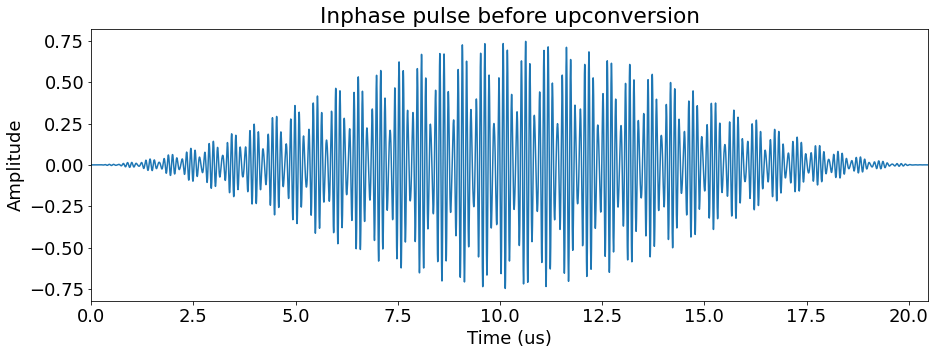

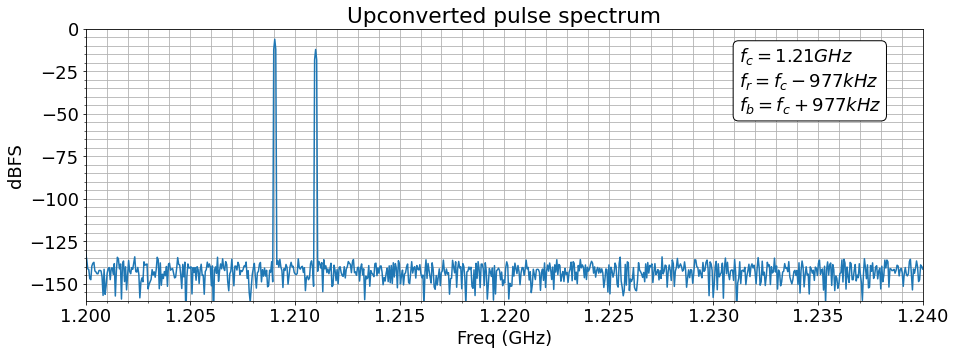

In [ ]:
#@title  { form-width: "1px" }
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
##################################################
## Gatepulse Architecture Prototype
##
## This file is a python sketch for a pulse generation architecture
## to be deployed on the Phaser Hardware of the Sinnara ecosystem.
## Its goal is to produce pulses for single and multi qbit 
## operations on-the-fly with a certain set of parameters.
## 
##################################################
## Author: Norman Krackow
## Company: QUARTIQ GmbH
## Pulse: two tone around 1.21GHz
##################################################
 
 
# %% Includes
# ================================================
 
import numpy as np
import matplotlib.pyplot as plt
 
 
# %% Helper functions
# ================================================
 
def dbspec(data):
    '''Returns positive freq spectrum in dBFS (+-1). Half width of data input.'''
    
    return 20*np.log10((abs(np.fft.fft(data)[:int(len(data)/2)]))/(len(data)/2))
 
 
def match_f(f,nr_samples,rate):
    '''Returns matched freq so there are integer periods in nr_samples'''
    
    periods=round((f*nr_samples)/rate)
    return (periods*rate)/nr_samples
 
 
def upsample(data,factor):
    '''returns ideal upsampled data via zero padding in fft'''
    
    nr_zeros=int((factor-1)*len(data))       # nr zeros to pad
    data_fft=np.fft.fft(data)*factor
    data_fft_zp=np.append(data_fft[:int(len(data_fft)/2)],np.zeros(nr_zeros))
    data_fft_zp=np.append(data_fft_zp,data_fft[int(len(data_fft)/2):])
    
    return np.fft.ifft(data_fft_zp)  # upsampled sig
 
 
def add_noise(data):
    '''add 16 bit quantization noise relative to +-1'''
    
    noise_power=(2**-16)/np.sqrt(12)         # textbook magic
    return data+np.random.normal(0,noise_power,len(data))
    
 
# %% Plotting control
# ================================================
    
plt.rc('font', size=18)
 
plotting=True             # plot output setting
 
 
# %% Fundamental Parameters
# ================================================
 
R = 500E6                 # Sample Rate 500MHz
 
T = R**-1                 # Sampling period 2ns
 
 
# %% Free Parameters
# ================================================
 
M = 1024                  # FFT size
 
L = 10240                 # Total number of samples in pulse
 
N = 5                     # first path base upsampling factor (fft tone spacing of first path)
 
f_0 = 10E6                # first path DDS modulation freq
 
f_1 = 200E6               # DAC DDS freq
 
f_2 = 1E9                 # external mixer freq
 
 
# %% FFT Coefficients
# ================================================
 
a_m=np.zeros(M,dtype=complex)   # complex fft parameters
 
a_m[-10] = M/2            # (real) cosine at -10th freq with weight 1/4
 
a_m[10] = 1j*M/4          # (imag) sine at +10th freq with weight 1/2
 
 
# %% Pulseshape FFT Coefficients
# ================================================
 
p_m = np.zeros(M,dtype=complex)   # complex pulseshape fft parameters
 
# Hann/raised cosine Window 
 
p_m[0] = M/2              # DC offset
 
p_m[1] = -M/4              
 
p_m[-1] = -M/4
 
 
# %% Following Parameters
# ================================================
 
P = L/(M*N)               # Number of FFT blocks of first path in full pulse
 
assert P%1 == 0           ,"Parameter collision!"
 
K = L/M                   # Pulseshape upsampling factor
 
assert K%1 == 0           ,"Pulselength not dividable by fft size"
 
t_P = L*T                 # total Pulse time
 
print(f'Total Pulse Time: {t_P*10**6}us ({L} Samples)')
 
# Match mixing frequency to fit into the samples with integer multiples of whole periods.
# This avoids weird leakage artifacts when plotting the spectra.
# Not necessary in real implementation.
 
f_0_m = match_f(f_0,L,R)  # first path DDS modulation freq matched
 
 
# compute and print frequency components
 
nr_freqs=0                # number of frequencys in first path
 
tone_spacing=R/(N*M)      # tone spacing of first path
 
f_c=f_0+f_1+f_2           # final carrier after 3x upconversion  
 
 
# %% STFT, gating, upsampling
# ================================================
 
STFT_block=np.fft.ifft(a_m)
sig_gated=STFT_block
for i in range(int(P-1)):
    sig_gated=np.append(sig_gated,STFT_block)
 
sig_us=upsample(sig_gated,N)
 
 
 
# %% Generate carrier and modulate
# ================================================
 
pulse_time=np.linspace(0,t_P-T,L)# timeseries for the whole pulse
 
carrier_0=np.exp(2j*np.pi*f_0_m*pulse_time)
 
pulse_modu=sig_us*carrier_0     # modulated pulse complex
 
 
# %% Generate pulseshape and shape
# ================================================
 
shape=np.fft.ifft(p_m).real     # base shape
 
shape_us=upsample(shape,K).real # upsampled shape
 
pulse=pulse_modu*shape_us       # final pulse before DAC
 
pulse=add_noise(pulse)          # add awgn
 
pulse_spec=dbspec(pulse)        # pulse spectrum
 
 
# %% Plotting
# ================================================
 
if plotting:
    
    fig,ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].plot(STFT_block.real,label='Inphase')
    ax[0].plot(STFT_block.imag,label='Quadrature')
    ax[0].set_title('Inphase/Quadrature STFT output')
    ax[0].set_ylabel('Amplitude rel. full scale')
    ax[0].set_xlabel('Samples')
    ax[0].set_xlim(0,M)
    ax[0].legend(loc='upper right')
    
    ax[1].plot(shape)
    ax[1].set_title('Pulseshape')
    ax[1].set_ylabel('Amplitude rel. full scale')
    ax[1].set_xlabel('Samples')
    ax[1].set_xlim(0,M)
    
    
    fig,ax = plt.subplots(1, 1, figsize=(15, 5))
    ax.plot(pulse_time*10**6,pulse.real)
    ax.set_title('Inphase pulse before upconversion')
    ax.set_ylabel('Amplitude')
    ax.set_xlabel('Time (us)')
    ax.set_xlim(0,t_P*10**6)
    
    # virtually shift Pulse up to f_1+f_2 --> tones at f_0+f_1+f_2+-((m/M)*R/N)
    
    f_low=(f_1+f_2)*10**-9      # lower bound of freq spectrum
    f_up=f_low+(R/2)*10**-9     # upper bound of freq spectrum
    pulse_freqs=np.linspace(f_low,f_up,int(L/2))
    
    fig,ax = plt.subplots(1, 1, figsize=(15, 5))
    ax.plot(pulse_freqs,pulse_spec)
    ax.set_title('Upconverted pulse spectrum')
    ax.set_ylabel('dBFS')
    ax.set_xlabel('Freq (GHz)')
    ax.set_xlim(1.2,1.24)
    ax.set_ylim(-160,0)
    ax.grid(True, which='both')
    ax.minorticks_on()
    ax.annotate(f'$f_c=1.21GHz$ \n$f_r=f_c-977kHz$ \n$f_b=f_c+977kHz$',
                xy=(0.78, 0.7), xycoords='axes fraction',
                bbox=dict(boxstyle='round', fc='w'))

## Open questions
 
* Window (if different from rectangular window)
  * Impact of spectral leakage on phase space trajectory
  * Impact on STFT/FFT decomposability
  * Required for spectral narrowness?
  * Or is it easier, faster and better for numerics to use the frequency components to tailor the overall window?
  * For the example above you could try it with two triplets of tones (a repeated Hann window for each sideband) and no external window at all
* Constraints
  * Two chains enough? What about carrier?
  * $M, N, P, R$ constraints useful and acceptable?
* Better benchmark example
  * Use more tones
  * Exploit tones to suppress leakage at some other mode frequency inside (at one of the inaccessible tones) the primary spectral window
  * Try with rectangular window: use tones to cancel spectral leakage
* Carrier chirp? Mode chirp?

* Double sideband modulation with the DAC $f_1$ DDS set to exactly the carrier with the $f_0$ DDS set exactly to one mode. Then detune with the STFT parameters, ensuring closed trajectories. Red and blue sideband would see exactly mirrored tones around the rabi carrier. Individual equalization via STFT parameters would of course not be possible in this case. Example spectrum:

Total Pulse Time: 20.48us (10240 Samples)


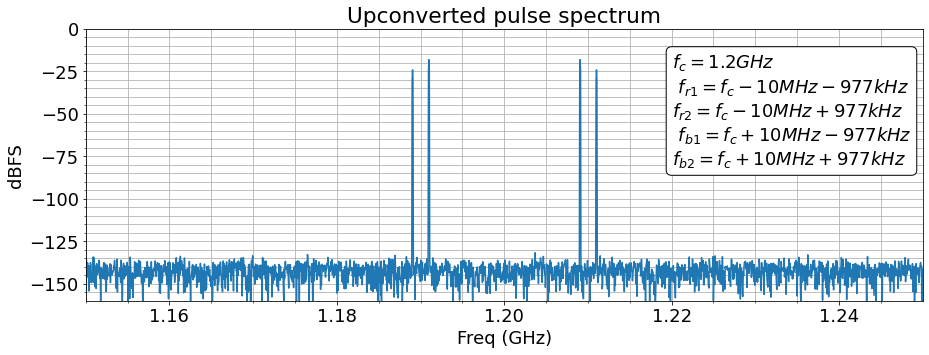

In [ ]:
#@title  { form-width: "1px" }
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
##################################################
## Gatepulse Architecture Prototype
##
## This file is a python sketch for a pulse generation architecture
## to be deployed on the Phaser Hardware of the Sinnara ecosystem.
## Its goal is to produce pulses for single and multi qbit 
## operations on-the-fly with a certain set of parameters.
## 
##################################################
## Author: Norman Krackow
## Company: QUARTIQ GmbH
## Pulse: four tone with (real) double sideband modulation around 1.2GHz
##################################################


# %% Includes
# ================================================

import numpy as np
import matplotlib.pyplot as plt


# %% Helper functions
# ================================================

def dbspec(data):
    '''Returns positive freq spectrum in dBFS (+-1). Half width of data input.'''
    
    return 20*np.log10((abs(np.fft.fft(data)[:int(len(data)/2)]))/(len(data)/2))


def match_f(f,nr_samples,rate):
    '''Returns matched freq so there are integer periods in nr_samples'''
    
    periods=round((f*nr_samples)/rate)
    return (periods*rate)/nr_samples


def upsample(data,factor):
    '''returns ideal upsampled data via zero padding in fft'''
    
    nr_zeros=int((factor-1)*len(data))       # nr zeros to pad
    data_fft=np.fft.fft(data)*factor
    data_fft_zp=np.append(data_fft[:int(len(data_fft)/2)],np.zeros(nr_zeros))
    data_fft_zp=np.append(data_fft_zp,data_fft[int(len(data_fft)/2):])
    
    return np.fft.ifft(data_fft_zp)  # upsampled sig


def add_noise(data):
    '''add 16 bit quantization noise relative to +-1'''
    
    noise_power=(2**-16)/np.sqrt(12)         # textbook magic
    return data+np.random.normal(0,noise_power,len(data))
    

# %% Plotting control
# ================================================
    
plt.rc('font', size=18)

plotting=True              # plot output setting


# %% Fundamental Parameters
# ================================================

R = 500E6                 # Sample Rate 500MHz

T = R**-1                 # Sampling period 2ns


# %% Free Parameters
# ================================================

M = 1024                  # FFT size

L = 10240                 # Total number of samples in pulse

N = 5                     # first path base upsampling factor (fft tone spacing of first path)

f_0 = 10E6                # first path DDS modulation freq

f_1 = 200E6               # DAC DDS freq

f_2 = 1E9                 # external mixer freq


# %% FFT Coefficients
# ================================================

a_m=np.zeros(M,dtype=complex)   # complex fft parameters

a_m[-10] = M/2            # (real) cosine at -10th freq with weight 1/4

a_m[10] = 1j*M/4          # (imag) sine at +10th freq with weight 1/2


# %% Pulseshape FFT Coefficients
# ================================================

p_m = np.zeros(M,dtype=complex)   # complex pulseshape fft parameters

# Hann/raised cosine Window 

p_m[0] = M/2              # DC offset

p_m[1] = -M/4              

p_m[-1] = -M/4


# %% Following Parameters
# ================================================

P = L/(M*N)               # Number of FFT blocks of first path in full pulse

assert P%1 == 0           ,"Parameter collision!"

K = L/M                   # Pulseshape upsampling factor

assert K%1 == 0           ,"Pulselength not dividable by fft size"

t_P = L*T                 # total Pulse time

print(f'Total Pulse Time: {t_P*10**6}us ({L} Samples)')

# Match mixing frequency to fit into the samples with integer multiples of whole periods.
# This avoids weird leakage artifacts when plotting the spectra.
# Not necessary in real implementation.

f_0_m = match_f(f_0,L,R)  # first path DDS modulation freq matched

f_1_m = match_f(f_1,L,R)  # maatch DAC DDS freq to samples


# compute and print frequency components

nr_freqs=0                # number of frequencys in first path

tone_spacing=R/(N*M)      # tone spacing of first path

f_c=f_0+f_1+f_2           # final carrier after 3x upconversion  



# %% STFT, gating, upsampling
# ================================================

STFT_block=np.fft.ifft(a_m)
sig_gated=STFT_block
for i in range(int(P-1)):
    sig_gated=np.append(sig_gated,STFT_block)

sig_us=upsample(sig_gated,N)



# %% Generate carrier and modulate
# ================================================

pulse_time=np.linspace(0,t_P-T,L)# timeseries for the whole pulse

carrier_0=np.exp(2j*np.pi*f_0_m*pulse_time)

pulse_modu_0=sig_us*carrier_0     

carrier_1=np.exp(2j*np.pi*f_1_m*pulse_time)

pulse_modu=pulse_modu_0.real*carrier_1.real  # modulated pulse real


# %% Generate pulseshape and shape
# ================================================

shape=np.fft.ifft(p_m).real     # base shape

shape_us=upsample(shape,K).real # upsampled shape

pulse=pulse_modu*shape_us       # final pulse before DAC

pulse=add_noise(pulse)          # add awgn

pulse_spec=dbspec(pulse)    # pulse spectrum


# %% Plotting
# ================================================

if plotting:
    
    
    # virtually shift Pulse up to f_1+f_2 --> tones at f_0+f_1+f_2+-((m/M)*R/N)
    
    #f_low=(f_2)*10**-9       # lower bound of freq spectrum
    f_low=f_2*10**-9
    f_up=f_low+((R/2)*10**-9)   # upper bound of freq spectrum
    pulse_freqs=np.linspace(f_low,f_up,int(L/2))
    
    fig,ax = plt.subplots(1, 1, figsize=(15, 5))
    ax.plot(pulse_freqs,pulse_spec)
    ax.set_title('Upconverted pulse spectrum')
    ax.set_ylabel('dBFS')
    ax.set_xlabel('Freq (GHz)')
    ax.set_xlim(1.15,1.25)
    ax.set_ylim(-160,0)
    ax.grid(True, which='both')
    ax.minorticks_on()
    ax.annotate(f'$f_c=1.2GHz$ \n $f_{{r1}}=f_c-10MHz-977kHz$ \n$f_{{r2}}=f_c-10MHz+977kHz$ \n $f_{{b1}}=f_c+10MHz-977kHz$ \n$f_{{b2}}=f_c+10MHz+977kHz$',
                xy=(0.7, 0.5), xycoords='axes fraction',
                bbox=dict(boxstyle='round', fc='w'))